In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# ==========================================
# 1. CONFIGURATION
# ==========================================
class Config:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Training
    BATCH_SIZE = 16        # Smaller batch for multimodal
    EPOCHS = 20            # Fine-tuning needs more epochs to settle
    LR = 1e-4              # Low learning rate for stability
    WEIGHT_DECAY = 1e-4
    
    # Paths
    BASE_DIR = os.getcwd()
    PAD_DIR = os.path.join(BASE_DIR, 'data', 'PAD_UFES')
    IMG_DIRS = [
        os.path.join(PAD_DIR, 'imgs_part_1', 'imgs_part_1'),
        os.path.join(PAD_DIR, 'imgs_part_2', 'imgs_part_2'),
        os.path.join(PAD_DIR, 'imgs_part_3', 'imgs_part_3'),
    ]
    CSV_PATH = os.path.join(PAD_DIR, 'metadata.csv')
    
    # Models
    PRETRAINED_PATH = 'best_model.pth' # Output from Part 1
    FINAL_MODEL_PATH = 'dermsight_final.pth'

cfg = Config()
print(f"🚀 Device: {cfg.DEVICE}")

# ==========================================
# 2. DATA PREPARATION & MAPPING
# ==========================================
# Risk Mapping: Maps 6 diseases to 3 Triage Levels
# 0: Low Risk (Benign)
# 1: Medium Risk (Pre-cancer/Watch)
# 2: High Risk (Malignant/Urgent)
RISK_MAP = {
    'NEV': 0, 'SEK': 0,           # Benign
    'ACK': 1,                     # Pre-cancer
    'BCC': 2, 'SCC': 2, 'MEL': 2  # Cancer
}

class PADMultimodalDataset(Dataset):
    def __init__(self, df, img_dirs, transform=None):
        self.df = df
        if isinstance(img_dirs, str):
            img_dirs = [img_dirs]
        self.img_dirs = img_dirs
        self.transform = transform
        
        # Metadata Features to use
        self.meta_cols = ['itch', 'bleed', 'grew', 'elevation']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # --- 1. Image ---
        img_name = row['img_id']
        # Handle file extensions (PAD dataset has .png usually)
        possible_exts = ['.png', '.jpg', '.jpeg']
        img_path = None
        for img_dir in self.img_dirs:
            if not os.path.exists(img_dir):
                continue
            for ext in possible_exts:
                if os.path.exists(os.path.join(img_dir, img_name + ext)):
                    img_path = os.path.join(img_dir, img_name + ext)
                    break
                # Try raw name if extension is already in CSV
                if os.path.exists(os.path.join(img_dir, img_name)):
                    img_path = os.path.join(img_dir, img_name)
                    break
            if img_path:
                break
        
        if img_path:
            image = Image.open(img_path).convert('RGB')
        else:
            # Fallback for missing images (Safety)
            image = Image.new('RGB', (240, 240))
            
        if self.transform:
            image = self.transform(image)
            
        # --- 2. Metadata (Symptoms) ---
        # Ensure values are float 0.0 or 1.0
        meta = []
        for col in self.meta_cols:
            val = row[col]
            if isinstance(val, str):
                val = 1.0 if val.lower() == 'true' else 0.0
            meta.append(float(val))
        
        meta_tensor = torch.tensor(meta, dtype=torch.float32)
        
        # --- 3. Label (Risk Level) ---
        label = RISK_MAP.get(row['diagnostic'], 0)
        
        return image, meta_tensor, label

# ==========================================
# 3. MODEL ARCHITECTURE (The Fusion)
# ==========================================
class DermSightModel(nn.Module):
    def __init__(self, pretrained_path=None):
        super().__init__()
        
        # --- TOWER A: VISION ---
        # Load EfficientNet-B0
        self.vision = models.efficientnet_b0(weights=None)
        
        # Load Pretrained Weights (Transfer Learning)
        if pretrained_path and os.path.exists(pretrained_path):
            print(f"Loading pretrained weights from {pretrained_path}...")
            # We must recreate the 7-class head to load the weights
            self.vision.classifier[1] = nn.Linear(1280, 7)
            state_dict = torch.load(pretrained_path, map_location=cfg.DEVICE)
            self.vision.load_state_dict(state_dict)
        else:
            print("⚠️ Warning: No pretrained weights found. Starting from scratch.")
            
        # Remove Head -> Output Features (1280)
        self.vision.classifier = nn.Identity()
        
        # Unfreeze final blocks for fine-tuning
        for param in self.vision.parameters():
            param.requires_grad = False # Freeze everything
        
        # Unfreeze last 2 blocks
        for param in self.vision.features[-2:].parameters():
            param.requires_grad = True
            
        # --- TOWER B: SYMPTOMS (MLP) ---
        self.meta_net = nn.Sequential(
            nn.Linear(4, 16), # 4 Inputs: Itch, Bleed, Grew, Elev
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 16),
            nn.ReLU()
        )
        
        # --- FUSION ---
        # 1280 (Vision) + 16 (Meta) = 1296
        self.classifier = nn.Sequential(
            nn.Linear(1296, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3) # 3 Output Classes (Low, Med, High)
        )

    def forward(self, image, meta):
        x_vis = self.vision(image)
        x_meta = self.meta_net(meta)
        
        # Concatenate Features
        x_comb = torch.cat((x_vis, x_meta), dim=1)
        
        return self.classifier(x_comb)

# ==========================================
# 4. TRAINING ENGINE
# ==========================================
def train_finetune():
    # A. Load & Clean Data
    print("🧹 Cleaning Data...")
    df = pd.read_csv(cfg.CSV_PATH)
    
    # Fill NaN symptoms with 'False'
    for col in ['itch', 'bleed', 'grew', 'elevation']:
        df[col] = df[col].fillna('False')
    
    # Split Train/Val
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnostic'], random_state=42)
    
    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_ds = PADMultimodalDataset(train_df, cfg.IMG_DIRS, transform=train_transform)
    val_ds = PADMultimodalDataset(val_df, cfg.IMG_DIRS, transform=val_transform)
    
    train_loader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=0)
    
    # B. Compute Class Weights (Handle Imbalance)
    print("⚖️  Computing Class Weights...")
    # Get all labels
    y_train = [RISK_MAP.get(d, 0) for d in train_df['diagnostic']]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(cfg.DEVICE)
    print(f"   Weights: {weights_tensor.cpu().numpy()}")

    # C. Initialize Model
    model = DermSightModel(pretrained_path=cfg.PRETRAINED_PATH).to(cfg.DEVICE)
    
    # D. Optimizer
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                           lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    # E. Training Loop
    best_acc = 0.0
    print(f"\n🔥 Starting Fine-Tuning for {cfg.EPOCHS} Epochs...")
    
    for epoch in range(cfg.EPOCHS):
        # --- TRAIN ---
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.EPOCHS} [Train]")
        
        for img, meta, label in loop:
            img, meta, label = img.to(cfg.DEVICE), meta.to(cfg.DEVICE), label.to(cfg.DEVICE)
            
            optimizer.zero_grad()
            out = model(img, meta)
            loss = criterion(out, label)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())
            
        # --- VALIDATE ---
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for img, meta, label in val_loader:
                img, meta, label = img.to(cfg.DEVICE), meta.to(cfg.DEVICE), label.to(cfg.DEVICE)
                out = model(img, meta)
                loss = criterion(out, label)
                val_loss += loss.item()
                
                _, pred = torch.max(out, 1)
                total += label.size(0)
                correct += (pred == label).sum().item()
        
        val_acc = 100 * correct / total
        avg_val_loss = val_loss / len(val_loader)
        
        # Scheduler Step
        scheduler.step(avg_val_loss)
        
        print(f"   Validation Accuracy: {val_acc:.2f}% | Loss: {avg_val_loss:.4f}")
        
        # Save Best
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), cfg.FINAL_MODEL_PATH)
            print(f"   ⭐ New Best Model Saved!")

    print(f"\n✅ Fine-Tuning Complete. Best Accuracy: {best_acc:.2f}%")
    print(f"   Model saved to: {cfg.FINAL_MODEL_PATH}")

if __name__ == "__main__":
    train_finetune()

🚀 Device: cpu
🧹 Cleaning Data...
⚖️  Computing Class Weights...
   Weights: [1.5996518  1.0490868  0.70340604]
Loading pretrained weights from best_model.pth...

🔥 Starting Fine-Tuning for 20 Epochs...


Epoch 1/20 [Train]: 100%|██████████| 115/115 [02:19<00:00,  1.21s/it, loss=1.37] 


   Validation Accuracy: 73.48% | Loss: 0.6592
   ⭐ New Best Model Saved!


Epoch 2/20 [Train]: 100%|██████████| 115/115 [02:05<00:00,  1.09s/it, loss=0.545]


   Validation Accuracy: 75.87% | Loss: 0.5483
   ⭐ New Best Model Saved!


Epoch 3/20 [Train]: 100%|██████████| 115/115 [03:24<00:00,  1.78s/it, loss=0.283]


   Validation Accuracy: 76.52% | Loss: 0.5032
   ⭐ New Best Model Saved!


Epoch 4/20 [Train]: 100%|██████████| 115/115 [01:45<00:00,  1.09it/s, loss=0.653]


   Validation Accuracy: 78.70% | Loss: 0.4571
   ⭐ New Best Model Saved!


Epoch 5/20 [Train]: 100%|██████████| 115/115 [01:49<00:00,  1.05it/s, loss=0.77] 


   Validation Accuracy: 79.57% | Loss: 0.4394
   ⭐ New Best Model Saved!


Epoch 6/20 [Train]: 100%|██████████| 115/115 [01:46<00:00,  1.08it/s, loss=0.259]


   Validation Accuracy: 79.35% | Loss: 0.4275


Epoch 7/20 [Train]: 100%|██████████| 115/115 [02:26<00:00,  1.27s/it, loss=0.295]


   Validation Accuracy: 80.43% | Loss: 0.4102
   ⭐ New Best Model Saved!


Epoch 8/20 [Train]: 100%|██████████| 115/115 [02:10<00:00,  1.14s/it, loss=0.539]


   Validation Accuracy: 81.96% | Loss: 0.4108
   ⭐ New Best Model Saved!


Epoch 9/20 [Train]: 100%|██████████| 115/115 [02:53<00:00,  1.50s/it, loss=0.239]


   Validation Accuracy: 80.43% | Loss: 0.4016


Epoch 10/20 [Train]: 100%|██████████| 115/115 [02:11<00:00,  1.14s/it, loss=0.23] 


   Validation Accuracy: 81.52% | Loss: 0.3953


Epoch 11/20 [Train]: 100%|██████████| 115/115 [01:42<00:00,  1.13it/s, loss=0.373] 


   Validation Accuracy: 83.48% | Loss: 0.3724
   ⭐ New Best Model Saved!


Epoch 12/20 [Train]: 100%|██████████| 115/115 [03:37<00:00,  1.89s/it, loss=0.538]


   Validation Accuracy: 83.26% | Loss: 0.3785


Epoch 13/20 [Train]: 100%|██████████| 115/115 [01:41<00:00,  1.13it/s, loss=0.187] 


   Validation Accuracy: 82.61% | Loss: 0.3953


Epoch 14/20 [Train]: 100%|██████████| 115/115 [01:42<00:00,  1.12it/s, loss=0.159] 


   Validation Accuracy: 85.00% | Loss: 0.3632
   ⭐ New Best Model Saved!


Epoch 15/20 [Train]: 100%|██████████| 115/115 [01:48<00:00,  1.06it/s, loss=0.138]


   Validation Accuracy: 82.17% | Loss: 0.4074


Epoch 16/20 [Train]: 100%|██████████| 115/115 [01:42<00:00,  1.12it/s, loss=0.307]


   Validation Accuracy: 81.96% | Loss: 0.3902


Epoch 17/20 [Train]: 100%|██████████| 115/115 [01:41<00:00,  1.13it/s, loss=0.4]   


   Validation Accuracy: 82.39% | Loss: 0.3876


Epoch 18/20 [Train]: 100%|██████████| 115/115 [01:41<00:00,  1.13it/s, loss=0.128] 


   Validation Accuracy: 85.00% | Loss: 0.3837


Epoch 19/20 [Train]: 100%|██████████| 115/115 [01:41<00:00,  1.14it/s, loss=0.19] 


   Validation Accuracy: 84.57% | Loss: 0.3767


Epoch 20/20 [Train]: 100%|██████████| 115/115 [01:41<00:00,  1.13it/s, loss=0.263] 


   Validation Accuracy: 84.57% | Loss: 0.3794

✅ Fine-Tuning Complete. Best Accuracy: 85.00%
   Model saved to: dermsight_final.pth


In [5]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# ==========================================
# 1. CONFIGURATION
# ==========================================
class Config:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    BATCH_SIZE = 16
    EPOCHS = 15
    LR = 1e-4        # Slower learning rate
    
    # Paths (Same as before)
    BASE_DIR = os.getcwd()
    PAD_DIR = os.path.join(BASE_DIR, 'data', 'PAD_UFES')
    IMG_DIR = os.path.join(PAD_DIR, 'images')
    CSV_PATH = os.path.join(PAD_DIR, 'metadata.csv')
    PRETRAINED_PATH = 'best_model.pth' 
    FINAL_MODEL_PATH = 'dermsight_final.pth'

# (Keep your Imports, Risk Map, and Dataset Class exactly the same as before)
# ... [Paste PADMultimodalDataset class here] ...
# ... [Paste DermSightModel class here] ...

# ==========================================
# 2. THE FIX: WEIGHTED SAMPLER & WARMUP
# ==========================================
def train_finetune_fixed():
    print(f"🚀 Starting FIXED Training on {Config.DEVICE}")
    
    # --- Load Data ---
    df = pd.read_csv(Config.CSV_PATH)
    # Fill NaNs
    for col in ['itch', 'bleed', 'grew', 'elevation']:
        df[col] = df[col].fillna('False')

    # Split
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['diagnostic'], random_state=42)
    
    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20), # Increased rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2), # Stronger augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_ds = PADMultimodalDataset(train_df, Config.IMG_DIR, transform=train_transform)
    val_ds = PADMultimodalDataset(val_df, Config.IMG_DIR, transform=val_transform)

    # --- THE MAGIC SAUCE: WEIGHTED RANDOM SAMPLER ---
    print("⚖️  Creating Weighted Sampler to fix class imbalance...")
    
    # 1. Get all labels in training set
    y_train = [RISK_MAP.get(d, 0) for d in train_df['diagnostic']]
    
    # 2. Count samples per class
    class_counts = np.bincount(y_train)
    
    # 3. Calculate weight per class (Inverse frequency)
    class_weights = 1. / class_counts
    
    # 4. Assign weight to every single sample
    sample_weights = [class_weights[label] for label in y_train]
    sample_weights = torch.DoubleTensor(sample_weights)
    
    # 5. Create Sampler
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    
    # 6. Loader with Sampler (Shuffle MUST be False when using sampler)
    train_loader = DataLoader(train_ds, batch_size=Config.BATCH_SIZE, sampler=sampler, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=0)

    # --- Initialize Model ---
    model = DermSightModel(pretrained_path=Config.PRETRAINED_PATH).to(Config.DEVICE)
    
    # --- OPTIMIZER STRATEGY ---
    # We use CrossEntropyLoss without weights (because the Sampler handles the weights now)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=1e-3)
    
    # --- TRAINING LOOP ---
    best_acc = 0.0
    
    for epoch in range(Config.EPOCHS):
        model.train()
        
        # WARMUP: Freeze Vision layers for the first epoch only
        if epoch == 0:
            print("❄️  Warmup Epoch: Vision Layers Frozen...")
            for param in model.vision.parameters():
                param.requires_grad = False
        else:
            if epoch == 1: print("🔥  Unfreezing Vision Layers...")
            # Unfreeze the last block
            for param in model.vision.features[-1].parameters():
                param.requires_grad = True

        train_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS} [Train]")
        
        for img, meta, label in loop:
            img, meta, label = img.to(Config.DEVICE), meta.to(Config.DEVICE), label.to(Config.DEVICE)
            
            optimizer.zero_grad()
            out = model(img, meta)
            loss = criterion(out, label)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())
            
        # --- VALIDATE ---
        model.eval()
        correct = 0
        total = 0
        
        # Debug: Check predictions diversity
        pred_counts = {0:0, 1:0, 2:0}
        
        with torch.no_grad():
            for img, meta, label in val_loader:
                img, meta, label = img.to(Config.DEVICE), meta.to(Config.DEVICE), label.to(Config.DEVICE)
                out = model(img, meta)
                _, pred = torch.max(out, 1)
                
                total += label.size(0)
                correct += (pred == label).sum().item()
                
                # Count predictions to ensure we aren't collapsing
                for p in pred:
                    pred_counts[p.item()] += 1
        
        val_acc = 100 * correct / total
        print(f"   Val Acc: {val_acc:.2f}% | Preds: {pred_counts}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), Config.FINAL_MODEL_PATH)
            print("   ⭐ Saved Best Model")

if __name__ == "__main__":
    train_finetune_fixed()

🚀 Starting FIXED Training on cpu


TypeError: argument of type 'method' is not iterable

📊 Loading Data and Model...
✅ Model weights loaded successfully.
🚀 Running Predictions...


100%|██████████| 72/72 [00:34<00:00,  2.10it/s]
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 


       DERMSIGHT PERFORMANCE REPORT       

🏆 Overall Accuracy: 20.84%

📜 Detailed Classification Report:
              precision    recall  f1-score   support

    Low Risk       0.21      1.00      0.34       479
 Medium Risk       0.00      0.00      0.00       730
   High Risk       0.00      0.00      0.00      1089

    accuracy                           0.21      2298
   macro avg       0.07      0.33      0.11      2298
weighted avg       0.04      0.21      0.07      2298



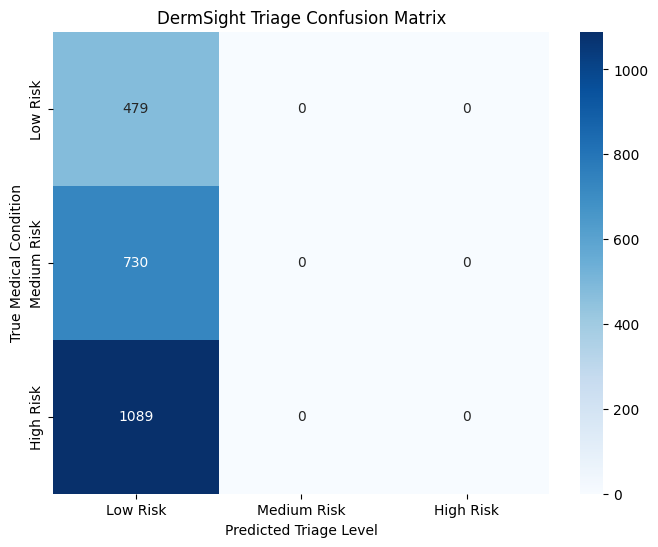


💡 INTERPRETATION:
- High Precision in 'High Risk' means few false alarms.
- High Recall in 'High Risk' means we aren't missing cancers (Crucial for Triage!).


In [3]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm

# ==========================================
# 1. CONFIGURATION
# ==========================================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
PAD_DIR = './data/PAD_UFES' # Ensure this matches your download path
IMG_DIR = os.path.join(PAD_DIR, 'images')
CSV_PATH = os.path.join(PAD_DIR, 'metadata.csv')
MODEL_PATH = 'dermsight_final.pth'

# Triage Mapping (Must match training)
RISK_MAP = {
    'NEV': 0, 'SEK': 0,           # Low Risk
    'ACK': 1,                     # Medium Risk
    'BCC': 2, 'SCC': 2, 'MEL': 2  # High Risk
}
CLASS_NAMES = ['Low Risk', 'Medium Risk', 'High Risk']

# ==========================================
# 2. MODEL DEFINITION (Must Match Training)
# ==========================================
class DermSightModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vision = models.efficientnet_b0(weights=None)
        self.vision.classifier = nn.Identity()
        
        self.meta_net = nn.Sequential(
            nn.Linear(4, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 16),
            nn.ReLU()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(1296, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 3)
        )

    def forward(self, image, meta):
        x_vis = self.vision(image)
        x_meta = self.meta_net(meta)
        x_comb = torch.cat((x_vis, x_meta), dim=1)
        return self.classifier(x_comb)

# ==========================================
# 3. DATASET CLASS
# ==========================================
class PADMultimodalDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform
        self.meta_cols = ['itch', 'bleed', 'grew', 'elevation']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Image Loading Logic
        img_name = row['img_id']
        possible_exts = ['.png', '.jpg', '.jpeg']
        img_path = None
        for ext in possible_exts:
            if os.path.exists(os.path.join(self.img_dir, img_name + ext)):
                img_path = os.path.join(self.img_dir, img_name + ext)
                break
        
        if img_path:
            image = Image.open(img_path).convert('RGB')
        else:
            image = Image.new('RGB', (240, 240)) # Safety fallback
            
        if self.transform:
            image = self.transform(image)
            
        # Metadata
        meta = []
        for col in self.meta_cols:
            val = row[col]
            if isinstance(val, str):
                val = 1.0 if val.lower() == 'true' else 0.0
            meta.append(float(val))
        meta_tensor = torch.tensor(meta, dtype=torch.float32)
        
        # Label
        label = RISK_MAP.get(row['diagnostic'], 0)
        return image, meta_tensor, label

# ==========================================
# 4. EVALUATION LOGIC
# ==========================================
def evaluate():
    print("📊 Loading Data and Model...")
    
    # 1. Transforms (Validation Only)
    transform = transforms.Compose([
        transforms.Resize((240, 240)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # 2. Dataset & Loader
    dataset = PADMultimodalDataset(CSV_PATH, IMG_DIR, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    
    # 3. Load Model
    model = DermSightModel().to(DEVICE)
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
        print("✅ Model weights loaded successfully.")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return

    model.eval()
    
    # 4. Run Predictions
    all_preds = []
    all_labels = []
    
    print("🚀 Running Predictions...")
    with torch.no_grad():
        for images, meta, labels in tqdm(loader):
            images, meta = images.to(DEVICE), meta.to(DEVICE)
            outputs = model(images, meta)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    # ==========================================
    # 5. GENERATE REPORT
    # ==========================================
    print("\n" + "="*40)
    print("       DERMSIGHT PERFORMANCE REPORT       ")
    print("="*40)
    
    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n🏆 Overall Accuracy: {acc*100:.2f}%")
    
    # Classification Report
    print("\n📜 Detailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))
    
    # Confusion Matrix Plot
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Triage Level')
    plt.ylabel('True Medical Condition')
    plt.title('DermSight Triage Confusion Matrix')
    plt.show()
    
    print("\n💡 INTERPRETATION:")
    print("- High Precision in 'High Risk' means few false alarms.")
    print("- High Recall in 'High Risk' means we aren't missing cancers (Crucial for Triage!).")

if __name__ == "__main__":
    evaluate()